# Imports

In [5]:
%matplotlib inline
# %matplotlib qt
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
import sklearn.neighbors._unsupervised
from draw_utils import draw_3d_clusters, draw_spiral_clusters
from matplotlib.ticker import LogFormatterExponent
plt.rcParams['figure.figsize'] = [15, 10]

# Load Checkpoints

In [2]:
with open('./saved/ckpt.pickle', 'rb') as f:
    x = pickle.load(f)
x.keys()

dict_keys(['knn', 295, 290, 285, 280, 275, 270, 265, 260, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5])

# Preview clusters for 2d and 3d manifolds

In [84]:
k = 10
C = x[k]['C']
if C[0].X[0].shape[0] == 2:
    draw_spiral_clusters(C, k=x['knn'])
elif C[0].X[0].shape[0] == 3:
    draw_3d_clusters(C)

# Compute error plot

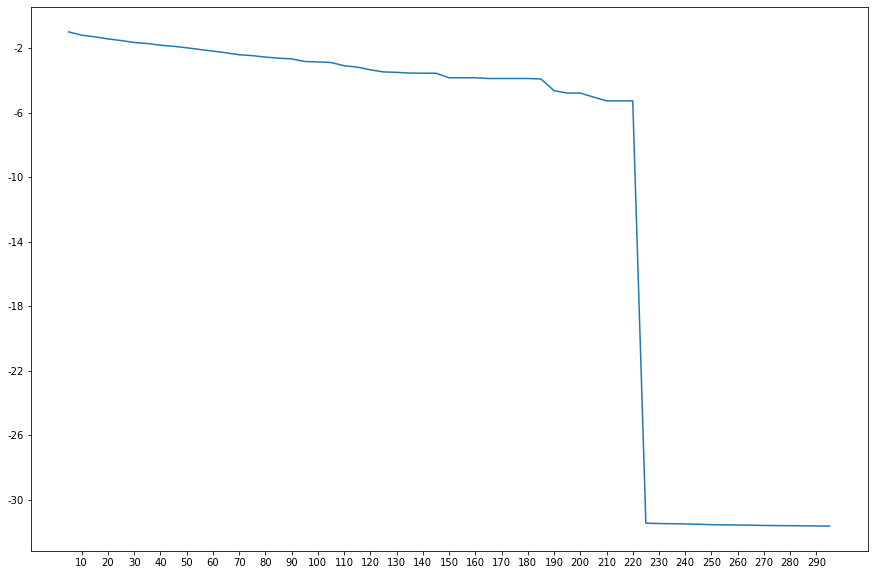

In [3]:
errors = {}
for it in x.keys():
    if it == 'knn':
        continue
        
    e = []
    C = x[it]['C']
    for Ci in C:
        F = Ci.F
        P = np.dot(F, F.T)
        samples = np.array(Ci.X).T
        mean_pos = np.mean(samples, axis=1, keepdims=True)
        s = samples - mean_pos

        proj = np.dot(P, s)
        e.append((s - proj)**2)
    errors[it] = np.mean(np.concatenate(e, axis=1), axis=(0, 1))

plt.semilogy(list(errors.keys()), list(errors.values()))
ax = plt.gca()
plt.xticks(list(errors.keys())[1::2])
ax.yaxis.set_major_formatter(LogFormatterExponent())
plt.show()

# Preview BSDS reconstruction

In [148]:
k = 90  # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(Ci.X).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos

    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0)
samples = np.concatenate(samples, axis=0)
proj.shape, samples.shape

((501592,), (501592,))

In [134]:
ith = 2000
s = samples[:, ith].reshape((8, 8))
p = proj[:, ith].reshape((8, 8))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s, cmap='gray')
ax2.imshow(p, cmap='gray')
ax3.imshow(np.clip(np.abs(p - s) * 255, 0, 255).astype(np.uint8), cmap='gray')

TypeError: list indices must be integers or slices, not tuple

# Preview VIDTIMIT reconstruction

In [4]:
k = 15 # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(Ci.X).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos
    
    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0).reshape((-1, 26, 26))
samples = np.concatenate(samples, axis=0).reshape((-1, 26, 26))
proj.shape, samples.shape

((885, 26, 26), (885, 26, 26))

In [5]:
from datasets_util import load_vidtimit
subject = 1
X = load_vidtimit('../data/vidtimit/', subject=subject, skip_pickle=False)
mean = np.mean(X, axis=0).reshape((26, 26))
std = np.std(X, axis=0).reshape((26, 26))
mean.shape, std.shape

((26, 26), (26, 26))

(885, 26, 26) (885, 26, 26)


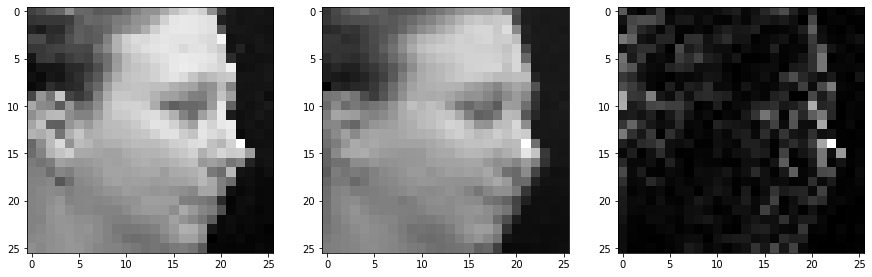

In [6]:
ith = 500
print(samples.shape, proj.shape)
s = samples[ith]
p = proj[ith]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s * std + mean, cmap='gray')
ax2.imshow(p * std + mean, cmap='gray')
ax3.imshow(np.abs(p - s), cmap='gray')

# Clusters preview

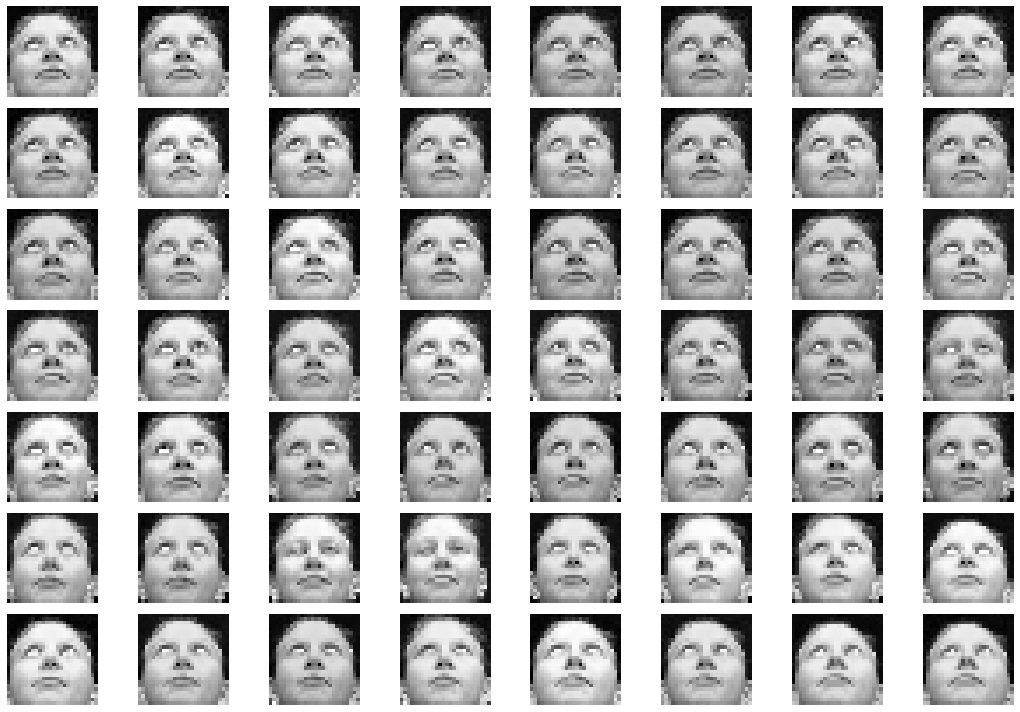

In [18]:
ith = 1
Ci = C[ith]
fig, axs = plt.subplots(nrows=int(np.sqrt(len(Ci.indices))), ncols=int(np.sqrt(len(Ci.indices)) + 1))
for i, ax in enumerate(axs.flat):
    if len(Ci.X) <= i:
        break
    ax.axis('off')
    s = Ci.X[i]
    ax.imshow((s.reshape((26, 26)) * std + mean), cmap='gray')
fig.tight_layout()

# MNIST

In [142]:
from mnist import MNIST
mndata = MNIST('../data/MNIST/')
images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels)
images.shape, labels.shape

((60000, 784), (60000,))

## GSI in original space

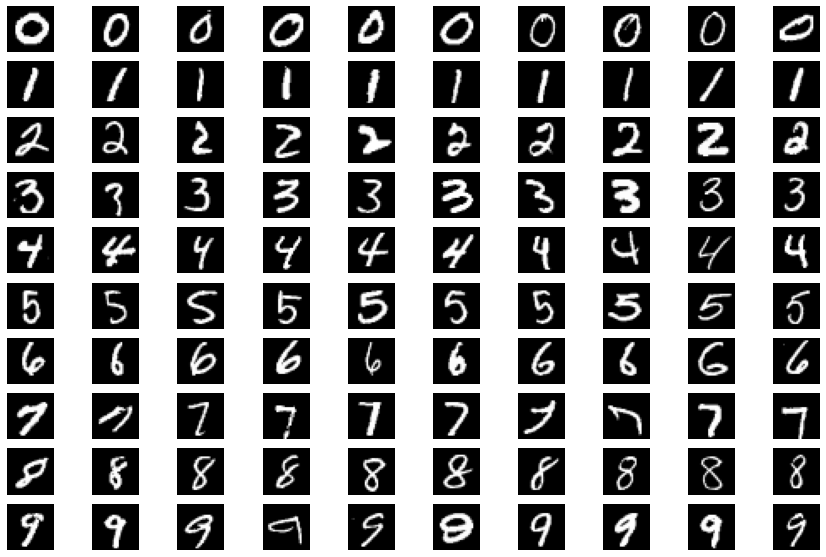

In [157]:
# Create balanced subset
s = 5000
X = np.zeros((s * 10, 784))
Y = np.zeros((s * 10))
for i in range(10):
    v = images[labels == i]
    X[s * i:s * (i + 1)] = v[np.random.choice(v.shape[0], size=s, replace=False)]
    Y[s * i:s * (i + 1)] = i
fig, axs = plt.subplots(ncols=10, nrows=10)
for ith, ax in enumerate(axs.flat):
    ax.imshow(X[s * (ith // 10) + ith % 10].reshape((28, 28)), cmap='gray')
    ax.axis('off')

In [158]:
knn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X)

In [159]:
# Compute GSI
n_idx = knn.kneighbors(X, return_distance=False)[:, 1:].squeeze(1)
GSI = np.sum(Y == Y[n_idx]) / X.shape[0]
GSI

0.97174